In [1]:
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
from os import getcwd
import os

sets=[('train'), ('val')]
classes = ["kangaroo", "raccoon"] #資料類別
wd = "."
# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(clss, image_id):
    in_file = open('G:/GitHub/CVDL/data/{}/annots/{}.xml'.format(clss, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()
    str_name_size = ""
    
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        str_name_size += " " + ",".join([str(a) for a in b]) + ',' + str(cls_id)
    
    return str_name_size

In [2]:
path = 'G:/GitHub/CVDL/data/{}/images/'.format(classes[0])
kangaroo_image_ids = []
for (dir,dirs,files) in os.walk(path):
    for file in files:
        kangaroo_path = dir.strip()+file.strip()
        file = file.strip().split('.')
        kangaroo_image_ids.append(kangaroo_path+convert_annotation(classes[0], file[0]))

kangaroo_image_ids[0:5]

['G:/GitHub/CVDL/data/kangaroo/images/00001.jpg 233,89,386,262,0 134,105,341,253,0',
 'G:/GitHub/CVDL/data/kangaroo/images/00002.jpg 156,114,240,309,0 222,117,415,306,0',
 'G:/GitHub/CVDL/data/kangaroo/images/00003.jpg 99,5,403,279,0',
 'G:/GitHub/CVDL/data/kangaroo/images/00004.jpg 15,71,316,233,0',
 'G:/GitHub/CVDL/data/kangaroo/images/00005.jpg 508,213,843,466,0']

In [3]:
path = 'G:/GitHub/CVDL/data/{}/images/'.format(classes[1])
raccoon_image_ids = []
for (dir,dirs,files) in os.walk(path):
    for file in files:
        raccoon_path = dir.strip()+file.strip()
        file = file.strip().split('.')
        raccoon_image_ids.append(raccoon_path+convert_annotation(classes[1], file[0]))

raccoon_image_ids[0:4]

['G:/GitHub/CVDL/data/raccoon/images/raccoon-1.jpg 81,88,522,408,1',
 'G:/GitHub/CVDL/data/raccoon/images/raccoon-10.jpg 130,2,446,488,1',
 'G:/GitHub/CVDL/data/raccoon/images/raccoon-100.jpg 548,10,954,520,1',
 'G:/GitHub/CVDL/data/raccoon/images/raccoon-101.jpg 86,53,400,356,1']

In [4]:
images_annots = kangaroo_image_ids + raccoon_image_ids

annotation_path = 'G:/GitHub/CVDL/homework/final_prj/all_img_annots.txt'
list_file = open(annotation_path, 'w')
for img in images_annots:
    list_file.write(img)
    list_file.write('\n')

In [5]:
import random

def random_shuffle(list_annots, percent):
    num = int(round(percent*len(list_annots)))  
    shuffled = list_annots[:]
    random.shuffle(shuffled)
    return shuffled[:num], shuffled[num:]

In [6]:
train_kangaroo, val_kangaroo = random_shuffle(kangaroo_image_ids, 0.85)

In [7]:
train_raccoon, val_raccoon = random_shuffle(raccoon_image_ids, 0.7)

In [8]:
train_path = 'G:/GitHub/CVDL/homework/final_prj/train_img_annots.txt'
list_file = open(train_path, 'w')
img_train = train_kangaroo + train_raccoon
for img in img_train:
    list_file.write(img)
    list_file.write('\n')
list_file.close()

val_path = 'G:/GitHub/CVDL/homework/final_prj/val_img_annots.txt'
list_file = open(val_path, 'w')
img_val = val_kangaroo + val_raccoon
for img in img_val:
    list_file.write(img)
    list_file.write('\n')
list_file.close()

In [1]:
import numpy as np
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data, get_GaussianBlur_data

# 將 train.py 所需要的套件載入
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [11]:
if not os.path.exists("G:/GitHub/CVDL/data/final_prj/model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    #os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Converting pretrained YOLOv3 weights for training


In [2]:
annotation_path = 'G:/GitHub/CVDL/homework/final_prj/train_img_annots.txt' # 轉換好格式的標註檔案
log_dir = 'G:/GitHub/CVDL/homework/final_prj/logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'G:/GitHub/CVDL/homework/final_prj/model_data/voc_classes.txt'
anchors_path = 'G:/GitHub/CVDL/homework/final_prj/model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [3]:
input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='G:/GitHub/CVDL/homework/final_prj/model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='G:/GitHub/CVDL/homework/final_prj/model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    # use custom yolo_loss Lambda layer.
    model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
        
    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

W0307 16:12:48.337143 10172 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0307 16:12:48.338905 10172 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0307 16:12:48.354125 10172 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0307 16:12:48.354125 10172 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.

Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:1

Load weights G:/GitHub/CVDL/homework/final_prj/model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


W0307 16:13:02.186367 10172 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 252 samples, val on 27 samples, with batch size 16.


W0307 16:13:04.011223 10172 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0307 16:13:04.012240 10172 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
15/15 [==============================] - 20s 1s/step - loss: 5580.9840 - val_loss: 2003.5471
Epoch 2/50
15/15 [==============================] - 12s 820ms/step - loss: 1187.2332 - val_loss: 559.2655
Epoch 3/50
15/15 [==============================] - 14s 924ms/step - loss: 441.7890 - val_loss: 300.8684
Epoch 4/50
15/15 [==============================] - 4s 283ms/step - loss: 266.5009 - val_loss: 187.2422
Epoch 5/50
15/15 [==============================] - 14s 939ms/step - loss: 204.5388 - val_loss: 136.1001
Epoch 6/50
15/15 [==============================] - 15s 976ms/step - loss: 164.4418 - val_loss: 127.6705
Epoch 7/50
15/15 [==============================] - 14s 931ms/step - loss: 140.4158 - val_loss: 104.6050
Epoch 8/50
15/15 [==============================] - 15s 977ms/step - loss: 122.6143 - val_loss: 95.2528
Epoch 9/50
15/15 [==============================] - 14s 934ms/step - loss: 111.4512 - val_loss: 87.6135
Epoch 10/50
15/15 [==============================] - 15s 1

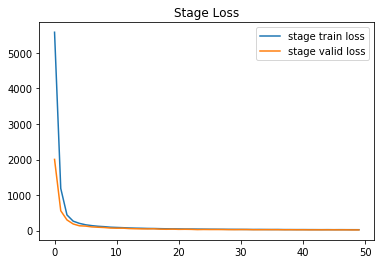

In [4]:
%matplotlib inline
# Collect results
stage_train_loss = model.history.history["loss"]
stage_valid_loss = model.history.history["val_loss"]
#stage_lr = model.history.history["lr"]

plt.plot(range(len(stage_train_loss)), stage_train_loss, label="stage train loss")
plt.plot(range(len(stage_valid_loss)), stage_valid_loss, label="stage valid loss")
plt.legend()
plt.title("Stage Loss")
plt.show()

#plt.plot(range(len(stage_lr)), lr, label="stage lr")
#plt.legend()
#plt.title("lr")
#plt.show()

In [5]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 6 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 252 samples, val on 27 samples, with batch size 6.
Epoch 51/100
42/42 [==============================] - 29s 689ms/step - loss: 20.0383 - val_loss: 16.3655
Epoch 52/100
42/42 [==============================] - 15s 357ms/step - loss: 17.2112 - val_loss: 16.5655
Epoch 53/100
42/42 [==============================] - 15s 356ms/step - loss: 15.8679 - val_loss: 15.1173
Epoch 54/100
42/42 [==============================] - 15s 359ms/step - loss: 15.4117 - val_loss: 14.4639
Epoch 55/100
42/42 [==============================] - 16s 372ms/step - loss: 14.9159 - val_loss: 14.7410
Epoch 56/100
42/42 [==============================] - 16s 376ms/step - loss: 15.2982 - val_loss: 15.9053
Epoch 57/100
42/42 [==============================] - 15s 365ms/step - loss: 14.4721 - val_loss: 14.6510

Epoch 00057: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 58/100
42/42 [==============================] - 15s 363ms/step - loss: 14.2894 - val_loss:

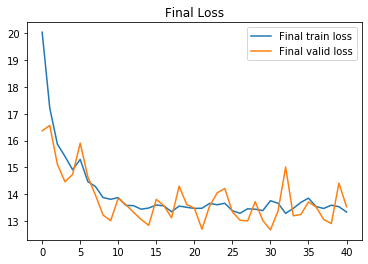

In [6]:
%matplotlib inline
# Collect results
final_train_loss = model.history.history["loss"]
final_valid_loss = model.history.history["val_loss"]

plt.plot(range(len(final_train_loss)), final_train_loss, label="Final train loss")
plt.plot(range(len(final_valid_loss)), final_valid_loss, label="Final valid loss")
plt.legend()
plt.title("Final Loss")
plt.show()

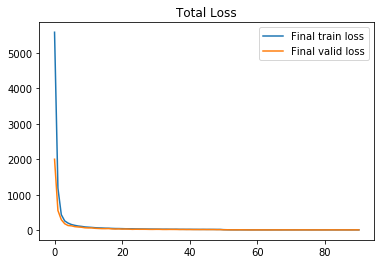

In [7]:
%matplotlib inline
# Collect results
ttl_train_loss = stage_train_loss + model.history.history["loss"]
ttl_valid_loss = stage_valid_loss + model.history.history["val_loss"]

plt.plot(range(len(ttl_train_loss)), ttl_train_loss, label="Final train loss")
plt.plot(range(len(ttl_valid_loss)), ttl_valid_loss, label="Final valid loss")
plt.legend()
plt.title("Total Loss")
plt.show()

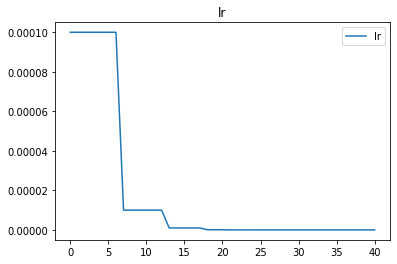

In [53]:
final_lr = model.history.history["lr"]

plt.plot(range(len(final_lr)), final_lr, label="lr")
plt.legend()
plt.title("lr")
plt.show()

In [32]:
log_dir = 'G:/GitHub/CVDL/homework/final_prj/logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'G:/GitHub/CVDL/homework/final_prj/model_data/voc_classes.txt'
from PIL import Image
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
#r_image = yolo_model.detect_image(image)

G:/GitHub/CVDL/homework/final_prj/logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [31]:
def bb_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [33]:
import pandas as pd
import math
df_result1 = pd.DataFrame(columns = ['class','filename','truth_box','detect_class','detect_box','condidence'])
test_path = 'G:/GitHub/CVDL/homework/final_prj/val_img_annots.txt'
with open(test_path) as f:
    lines = f.readlines()

for line in lines:
    lst_collect_1 = []
    
    #Assign class
    if 'kangaroo' in line:
        lst_collect_1.append('kangaroo')
    elif 'raccoon' in line:
        lst_collect_1.append('raccoon')    
    #Assign filename
    lst_collect_1.append(line[line.rfind('/')+1:line.rfind('.jpg')])
    #Assign truth_boxes
    lst_collect_1.append(line[line.rfind('.jpg')+5:])
    
    img , boxes, scores, classes  = yolo_model.detect_image(Image.open(line[:line.rfind('.jpg')+4]))
    #Assign detect result
    for i, c in enumerate(classes):
        lst_collect_2 = []
        lst_collect_2.append(class_names[c])
        lst_collect_2.append(str(boxes[i][1])+","+str(boxes[i][0])+","+str(boxes[i][3])+","+str(boxes[i][2]))
        lst_collect_2.append(scores[i])
    
        df_result1.loc[len(df_result1.index)] = lst_collect_1 + lst_collect_2

In [35]:
df_result1.tail(10)

class     filename                             truth_box detect_class  \
101  raccoon   raccoon-13                     55,28,393,313,1\n      raccoon   
102  raccoon  raccoon-154                    148,56,517,346,1\n      raccoon   
103  raccoon  raccoon-108                     99,53,402,464,1\n      raccoon   
104  raccoon   raccoon-67                     18,17,224,168,1\n      raccoon   
105  raccoon   raccoon-18                     32,25,201,130,1\n      raccoon   
106  raccoon  raccoon-148  32,177,174,316,1 309,172,428,315,1\n      raccoon   
107  raccoon  raccoon-148  32,177,174,316,1 309,172,428,315,1\n      raccoon   
108  raccoon  raccoon-115                    51,130,351,556,1\n      raccoon   
109  raccoon   raccoon-96                     28,25,203,175,1\n      raccoon   
110  raccoon   raccoon-94                    155,10,543,445,1\n      raccoon   

                                 detect_box  condidence  
101  59.987354,10.371144,395.26462,342.2443    0.992929  
102   153.07362,79.89135,518.37366,367.0774    0.898114  
103  116.31898,63.184013,476.36688,425.7109    0.976896  
104   13.810627,23.8062,248.66559,165.24016    0.996129  
105   35.13233,44.52288,180.9248,122.089264    0.900260  
106   36.947876,134.934,160.30704,345.82812    0.774841  
107   319.4614,171.95712,417.4514,324.62683    0.538871  
108     96.68737,153.59224,403.175,560.1096    0.890419  
109    47.19078,11.782249,209.8227,203.2388    0.988631  
110  207.69618,30.60336,490.83234,447.36014    0.995709

In [36]:
df_result2 = pd.DataFrame(columns = ['class','filename','detect_class','condidence','iou'])
for dfindex, row in df_result1.loc[df_result1["class"] == 'kangaroo',:].iterrows():
    #print("-------------",row["filename"],"-------------")    
    pdt = row["detect_box"].split(',')
    pdt_box = [float(pdt[0]),float(pdt[1]),float(pdt[2]),float(pdt[3])]
    dist = []
    iou = []       
    
    truth_info = str(row["truth_box"]).split()
    for truth in truth_info:
        gt = truth[:truth.rfind('.0')-1].split(',')
        gt_box = [int(gt[0]),int(gt[1]),int(gt[2]),int(gt[3])]
        iou.append(bb_iou(gt_box, pdt_box))
        dist.append(math.sqrt(((gt_box[0]-pdt_box[0])**2)+((gt_box[1]-pdt_box[1])**2)))
    
    
    df_result2.loc[len(df_result2.index)] = [row["class"],row["filename"],row["detect_class"],row["condidence"],iou[dist.index(min(dist))]]
            
#<-------------------------------------------------------------------------------->#
for dfindex, row in df_result1.loc[df_result1["class"] == 'raccoon',:].iterrows():
    #print("-------------",row["filename"],"-------------")    
    pdt = row["detect_box"].split(',')
    pdt_box = [float(pdt[0]),float(pdt[1]),float(pdt[2]),float(pdt[3])]
    dist = []
    iou = []       
    
    truth_info = str(row["truth_box"]).split()
    for truth in truth_info:
        gt = truth[:truth.rfind('.0')-1].split(',')
        gt_box = [int(gt[0]),int(gt[1]),int(gt[2]),int(gt[3])]
        iou.append(bb_iou(gt_box, pdt_box))
        dist.append(math.sqrt(((gt_box[0]-pdt_box[0])**2)+((gt_box[1]-pdt_box[1])**2)))
            
    df_result2.loc[len(df_result2.index)] = [row["class"],row["filename"],row["detect_class"],row["condidence"],iou[dist.index(min(dist))]]

In [38]:
kangaroo_gt = 0
raccoon_gt = 0
filename = []
for dfindex, row in df_result1.loc[df_result1["class"] == 'kangaroo',:].iterrows():
    if row["filename"] not in filename:
        filename.append(row["filename"])
        truth_info = str(row["truth_box"]).split()
        for truth in truth_info:
            kangaroo_gt += 1
filename = []
for dfindex, row in df_result1.loc[df_result1["class"] == 'raccoon',:].iterrows():
    if row["filename"] not in filename:
        filename.append(row["filename"])
        truth_info = str(row["truth_box"]).split()
        for truth in truth_info:
            raccoon_gt += 1

In [41]:
df_result3 = pd.DataFrame(columns = ['class','filename','detect_class','condidence','iou','tp','fp','acc_tp','acc_fp','precision','recall'])
acc_tp = 0
acc_fp = 0
for dfindex, row in df_result2.loc[df_result2["class"] == 'kangaroo',:].sort_values(by=['condidence'], ascending=False).iterrows():
    #print("-------------",row["filename"],"-------------")
    tp = 0
    fp = 0
    if row["iou"] >= 0.5:
        tp = 1
        fp = 0
    else:
        tp = 0
        fp = 1
        
    acc_tp += tp
    acc_fp += fp
    
    precision = acc_tp / (acc_tp + acc_fp) 
    recall = acc_tp / kangaroo_gt
    df_result3.loc[len(df_result3.index)] = [row["class"],row["filename"],row["detect_class"],row["condidence"],row["iou"],tp,fp,acc_tp,acc_fp,precision,recall]
#<-------------------------------------------------------------------------------->#   
acc_tp = 0
acc_fp = 0
for dfindex, row in df_result2.loc[df_result2["class"] == 'raccoon',:].sort_values(by=['condidence'], ascending=False).iterrows():
    #print("-------------",row["filename"],"-------------")
    tp = 0
    fp = 0
    if row["iou"] >= 0.5:
        tp = 1
        fp = 0
    else:
        tp = 0
        fp = 1
        
    acc_tp += tp
    acc_fp += fp
    
    precision = acc_tp / (acc_tp + acc_fp) 
    recall = acc_tp / raccoon_gt
    df_result3.loc[len(df_result3.index)] = [row["class"],row["filename"],row["detect_class"],row["condidence"],row["iou"],tp,fp,acc_tp,acc_fp,precision,recall]    

In [46]:
df_kangaroo = df_result3.loc[df_result3["class"] == 'kangaroo',:]
df_raccoon = df_result3.loc[df_result3["class"] == 'raccoon',:]

In [47]:
df_kangaroo.head(10)

class filename detect_class  condidence       iou tp fp acc_tp acc_fp  \
0  kangaroo    00164     kangaroo    0.998462  0.819308  1  0      1      0   
1  kangaroo    00051     kangaroo    0.998236  0.820203  1  0      2      0   
2  kangaroo    00055     kangaroo    0.995905  0.854593  1  0      3      0   
3  kangaroo    00101     kangaroo    0.995356  0.614040  1  0      4      0   
4  kangaroo    00118     kangaroo    0.993148  0.903298  1  0      5      0   
5  kangaroo    00028     kangaroo    0.993058  0.909295  1  0      6      0   
6  kangaroo    00179     kangaroo    0.993003  0.844845  1  0      7      0   
7  kangaroo    00074     kangaroo    0.988328  0.751608  1  0      8      0   
8  kangaroo    00118     kangaroo    0.987929  0.517575  1  0      9      0   
9  kangaroo    00164     kangaroo    0.982427  0.726014  1  0     10      0   

   precision    recall  
0        1.0  0.022727  
1        1.0  0.045455  
2        1.0  0.068182  
3        1.0  0.090909  
4        1.0  0.113636  
5        1.0  0.136364  
6        1.0  0.159091  
7        1.0  0.181818  
8        1.0  0.204545  
9        1.0  0.227273

In [48]:
df_raccoon.head(10)

class     filename detect_class  condidence       iou tp fp acc_tp  \
42  raccoon  raccoon-189      raccoon    0.999164  0.803234  1  0      1   
43  raccoon  raccoon-107      raccoon    0.999156  0.867103  1  0      2   
44  raccoon   raccoon-11      raccoon    0.998726  0.848078  1  0      3   
45  raccoon   raccoon-81      raccoon    0.998674  0.766554  1  0      4   
46  raccoon  raccoon-122      raccoon    0.998370  0.836295  1  0      5   
47  raccoon  raccoon-126      raccoon    0.998295  0.862082  1  0      6   
48  raccoon   raccoon-70      raccoon    0.998269  0.860018  1  0      7   
49  raccoon   raccoon-54      raccoon    0.998267  0.914326  1  0      8   
50  raccoon   raccoon-23      raccoon    0.998088  0.907196  1  0      9   
51  raccoon   raccoon-44      raccoon    0.998049  0.821569  1  0     10   

   acc_fp  precision    recall  
42      0        1.0  0.015385  
43      0        1.0  0.030769  
44      0        1.0  0.046154  
45      0        1.0  0.061538  
46      0        1.0  0.076923  
47      0        1.0  0.092308  
48      0        1.0  0.107692  
49      0        1.0  0.123077  
50      0        1.0  0.138462  
51      0        1.0  0.153846

In [49]:
import numpy as np
kangaroo_p = []
kangaroo_r = []
for i in np.arange(0, 1.1, 0.1):
    #print(str(round(i, 2))) 
    df_tmp = df_kangaroo.loc[df_kangaroo["recall"] >= round(i, 2),["precision","recall"]]
    if np.isnan(df_tmp["precision"].max()):
        max_value = 0
    else:
        max_value = df_tmp["precision"].max()
    kangaroo_p.append(max_value)
    kangaroo_r.append(round(i, 2))
    
kangaroo_ap = sum(kangaroo_p) / 11



raccoon_p = []
raccoon_r = []
for i in np.arange(0, 1.1, 0.1):
    #print(str(round(i, 2))) 
    df_tmp = df_raccoon.loc[df_raccoon["recall"] >= round(i, 2),["precision","recall"]]
    if np.isnan(df_tmp["precision"].max()):
        max_value = 0
    else:
        max_value = df_tmp["precision"].max()
    raccoon_p.append(max_value)
    raccoon_r.append(round(i, 2))
    
raccoon_ap = sum(raccoon_p) / 11

mAp = (kangaroo_ap + raccoon_ap)/2

In [50]:
print("kangaroo_ap",kangaroo_ap)
print("raccoon_ap",raccoon_ap)
print("mAp",mAp)

kangaroo_ap 0.7849503437738733
raccoon_ap 0.8776660237243188
mAp 0.8313081837490961


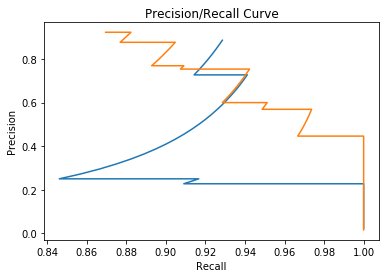

In [51]:
import matplotlib
import matplotlib.pyplot as plt
#from sklearn.metrics import precision_recall_curve
#plt.figure(1) 
plt.title('Precision/Recall Curve')# give plot a title
plt.xlabel('Recall')# make axis labels
plt.ylabel('Precision')

plt.plot(np.array(df_kangaroo.precision), np.array(df_kangaroo.recall))
plt.plot(np.array(df_raccoon.precision), np.array(df_raccoon.recall))
plt.show()

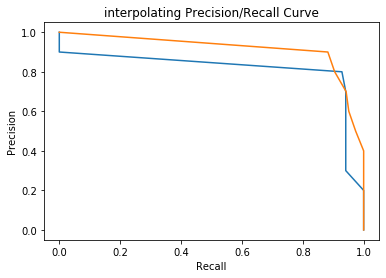

In [52]:
#plt.figure(1) 
plt.title('interpolating Precision/Recall Curve')# give plot a title
plt.xlabel('Recall')# make axis labels
plt.ylabel('Precision')

plt.plot(np.array(kangaroo_p), np.array(kangaroo_r))
plt.plot(np.array(raccoon_p), np.array(raccoon_r))
plt.show()

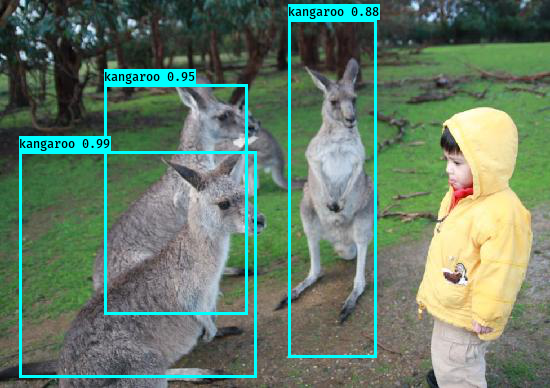

In [30]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/kangaroo/images/00037.jpg'))
img

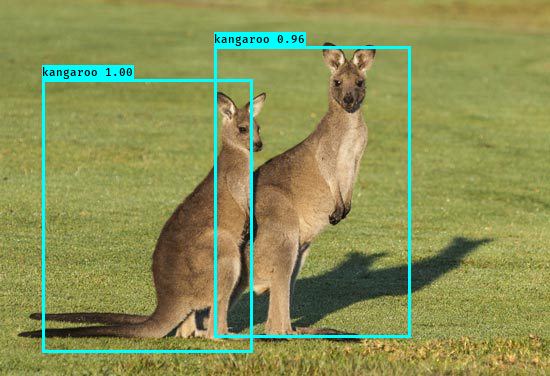

In [13]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/kangaroo/images/00051.jpg'))
img

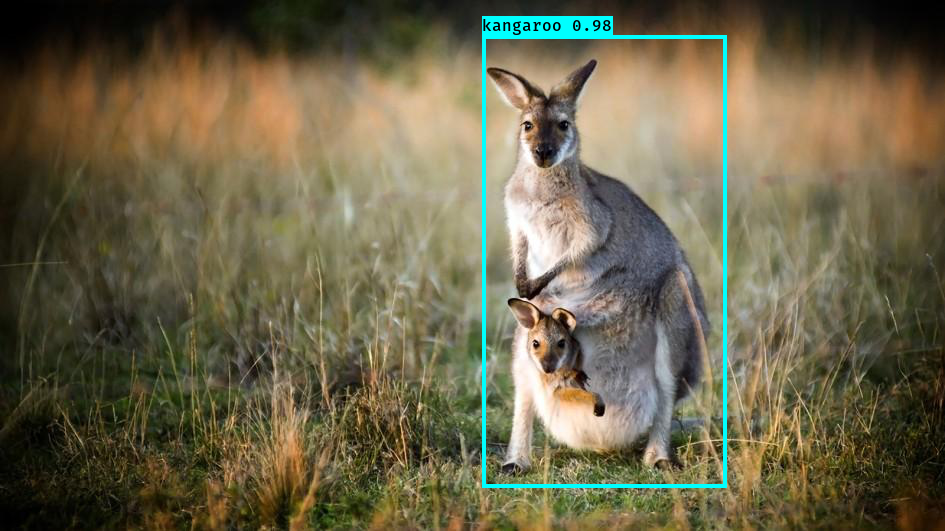

In [12]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/kangaroo/images/00044.jpg'))
img

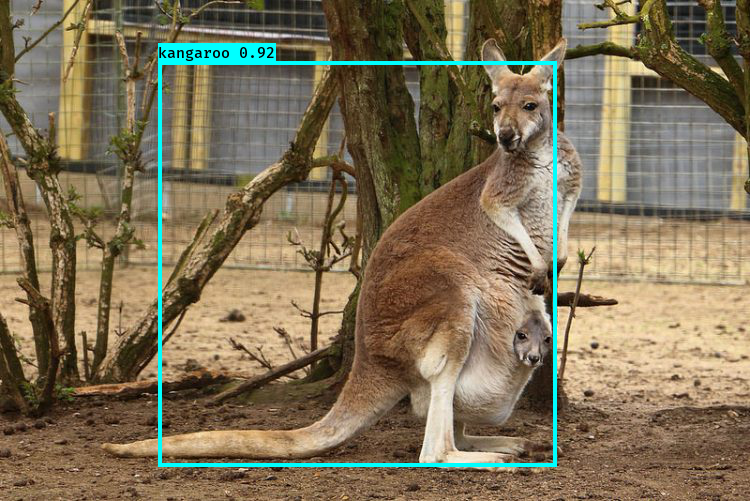

In [11]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/kangaroo/images/00020.jpg'))
img

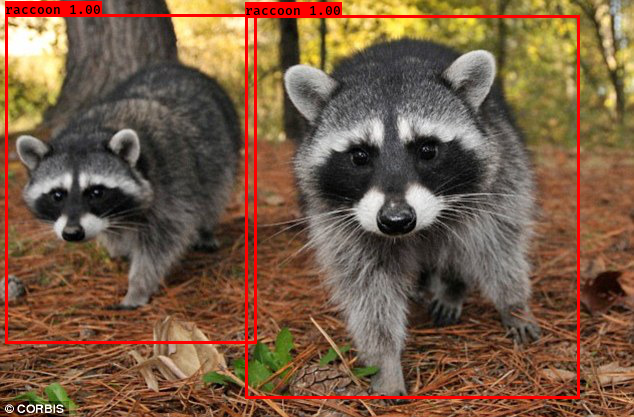

In [29]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/raccoon/images/raccoon-55.jpg'))
img

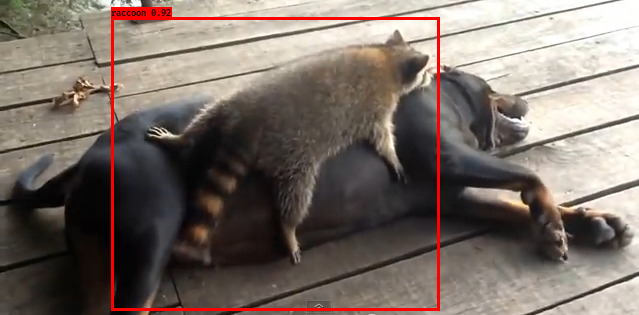

In [14]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/raccoon/images/raccoon-129.jpg'))
img

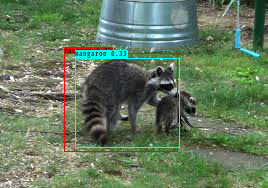

In [16]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/raccoon/images/raccoon-24.jpg'))
img

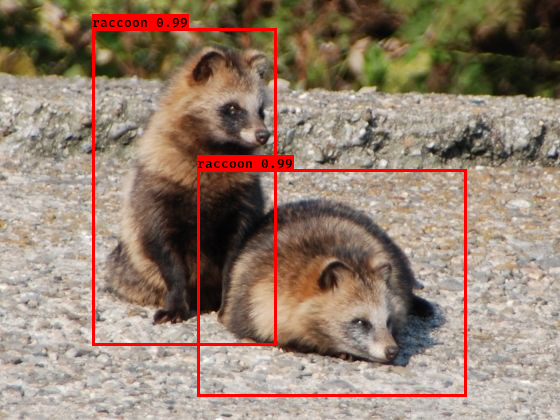

In [17]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/raccoon/images/raccoon-72.jpg'))
img

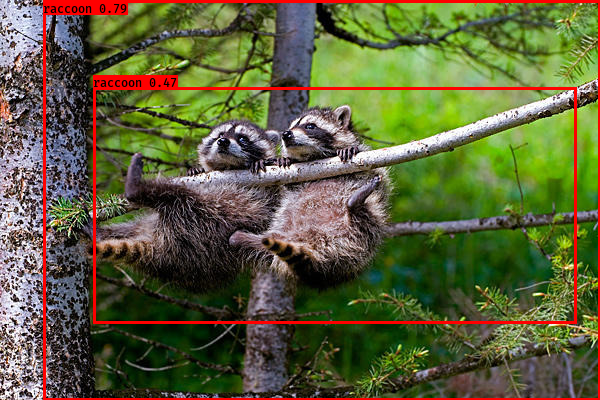

In [18]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/data/raccoon/images/raccoon-63.jpg'))
img

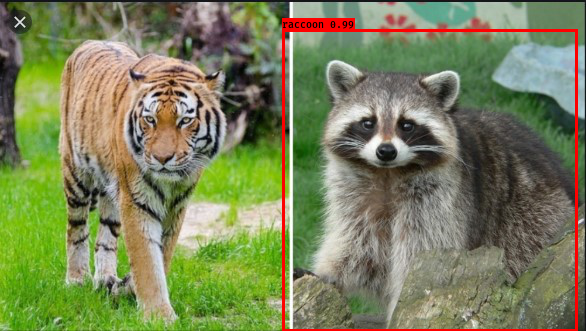

In [19]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/homework/final_prj/test_img/test01.jpg'))
img

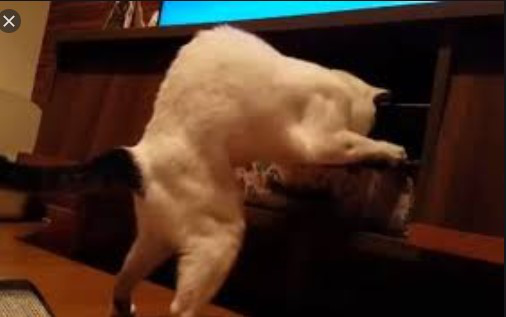

In [23]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/homework/final_prj/test_img/test06.jpg'))
img

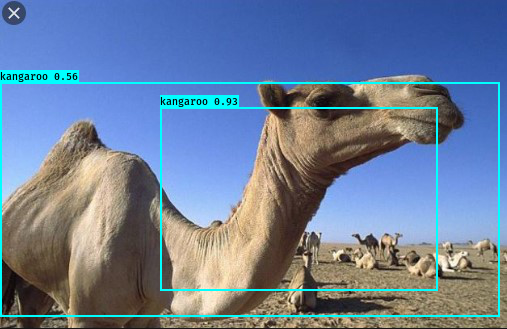

In [24]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/homework/final_prj/test_img/test07.jpg'))
img

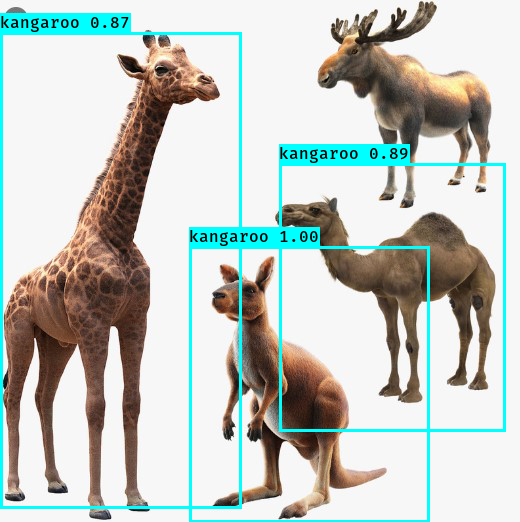

In [25]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/homework/final_prj/test_img/test08.jpg'))
img

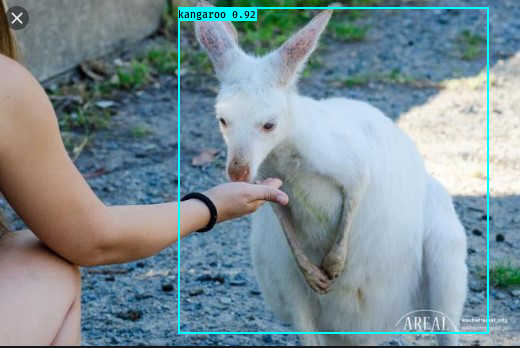

In [26]:
img, boxes, scores, classes = yolo_model.detect_image(Image.open('G:/GitHub/CVDL/homework/final_prj/test_img/test09.jpg'))
img

In [1]:
log_dir = 'G:/GitHub/CVDL/homework/final_prj/logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'G:/GitHub/CVDL/homework/final_prj/model_data/voc_classes.txt'
from PIL import Image
from yolo import YOLO, detect_video
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
#r_image = yolo_model.detect_image(image)

Using TensorFlow backend.
W0307 23:38:24.491414 11712 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0307 23:38:24.492435 11712 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0307 23:38:24.492435 11712 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0307 23:38:25.361759 11712 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.glo

G:/GitHub/CVDL/homework/final_prj/logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


W0307 23:38:37.095679 11712 deprecation.py:323] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [2]:
v_in_path = "G:/GitHub/CVDL/data/Kangaroo.mp4"
#v_in_path = "G:/GitHub/CVDL/data/Raccoon.mp4"
v_out_path = "G:/GitHub/CVDL/homework/final_prj/Kangaroo_result.mp4"
#v_out_path = "G:/GitHub/CVDL/homework/final_prj/Raccoon_result.mp4"
detect_video(yolo_model, video_path=v_in_path, output_path=v_out_path)

  0%|                                                                                         | 0/1800 [00:00<?, ?it/s]

!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>


100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [01:45<00:00, 17.05it/s]
